<a href="https://colab.research.google.com/github/CHGROSJEAN/2024_MLEES/blob/main/Projet/Projet_Charlotte_Grosjean_GMM_2Stations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import libraries and data


In [1]:
# Import
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import os
from shapely.geometry import Point
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.preprocessing import StandardScaler


Download data sets

In [2]:
# Reading the Excel files
grandvennes = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/GrandVennes.xlsx")
riandpre = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/RiandPre.xlsx")



# Displaying the first few rows of each dataset
print("Data from Grand-Vennes:")
print(grandvennes.head())

print("\nData from Riand-Pré:")
print(riandpre.head())

Data from Grand-Vennes:
   Index             DateTime  Precipitation
0      1  07.01.2023 08:27:54              0
1      2  07.01.2023 08:30:54              0
2      3  07.01.2023 08:33:54              0
3      4  07.01.2023 08:36:54              0
4      5  07.01.2023 08:39:54              0

Data from Riand-Pré:
   Index             DateTime  Precipitation
0      1  09.11.2022 00:03:39              0
1      2  09.11.2022 00:06:39              0
2      3  09.11.2022 00:09:39              0
3      4  09.11.2022 00:12:39              0
4      5  09.11.2022 00:15:39              0


In [3]:
# Ensuring the 'DateTime' the column is of datetime type for both datasets
grandvennes['DateTime'] = pd.to_datetime(grandvennes['DateTime'], dayfirst=True)
riandpre['DateTime'] = pd.to_datetime(riandpre['DateTime'], dayfirst=True)

# Setting the DateTime column as the index for easier time-based operations
grandvennes.set_index('DateTime', inplace=True)
riandpre.set_index('DateTime', inplace=True)

# 1. SIMPLE GMM BASELINE FOR 2 STATIONS

Frist step, simple GMM for 2 correlated stations : Grand-Vennes and Riand-Pré.

**1.0 Preprocessing and visualization**


Pre-processing the data to ensure the data is clean following the following steps:
- Setting DateTime as the index
- Selecting the period (data for both station)
- Converting drops in mm


<ipython-input-4-dd174b548b5a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grandvennes_filtered['Precipitation_mm'] = grandvennes_filtered['Precipitation'] * 0.01
<ipython-input-4-dd174b548b5a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  riandpre_filtered['Precipitation_mm'] = riandpre_filtered['Precipitation'] * 0.01


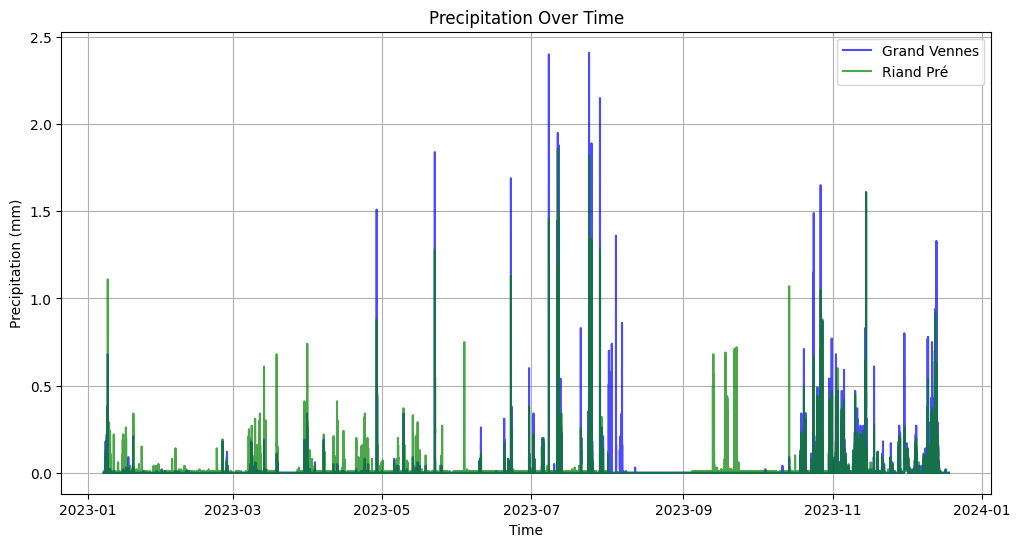

In [4]:
#Finding the common time period between the two datasets
start_time = max(grandvennes.index.min(), riandpre.index.min())
end_time = min(grandvennes.index.max(), riandpre.index.max())

# Filtering both datasets to the common time period
grandvennes_filtered = grandvennes.loc[start_time:end_time]
riandpre_filtered = riandpre.loc[start_time:end_time]

# Converting precipitation from drops to mm ( 1 drop = 0.01 mm)
grandvennes_filtered['Precipitation_mm'] = grandvennes_filtered['Precipitation'] * 0.01
riandpre_filtered['Precipitation_mm'] = riandpre_filtered['Precipitation'] * 0.01

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(grandvennes_filtered.index, grandvennes_filtered['Precipitation_mm'], label='Grand Vennes', color='blue', alpha=0.7)
plt.plot(riandpre_filtered.index, riandpre_filtered['Precipitation_mm'], label='Riand Pré', color='green', alpha=0.7)

# Adding labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation Over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

To work with 2 staitions in a GMM model, the data needs to be aligned and merge in 1 dataset. Here are the steps followed to create this dataset:
- Remove the seconds units to have minute precision
- Aligning both datasets to the period (Both dataset have 3 minutes interval)
- If some time points are still missing from one station, drop them from the analysis
- Merge datasets in 1 dataset for GMM

Normally, sensors are set to measure every three minutes, starting with the full hour, so that stations take measurements at the same minutes for easier analysis.

So, when we remove the seconds, we round up to the previous minute to keep this matching.

We still have a step to align the two datasets, as some sensors are not set to the same minutes and are therefore out of sync.

In [5]:
# Round down the DateTime to the previous minute (removes seconds, truncating)
grandvennes_filtered.index = grandvennes_filtered.index.floor('min')  # rounded to the nearest lower minute
riandpre_filtered.index = riandpre_filtered.index.floor('min')

# Resampling to the closest 3-minute interval and filling missing values with NaN
grandvennes_resampled = grandvennes_filtered.resample('3min').mean()
riandpre_resampled = riandpre_filtered.resample('3min').mean()

# Align both datasets to the common period (intersection of their timestamps)
start_time = max(grandvennes_resampled.index.min(), riandpre_resampled.index.min())
end_time = min(grandvennes_resampled.index.max(), riandpre_resampled.index.max())

grandvennes_aligned = grandvennes_resampled.loc[start_time:end_time]
riandpre_aligned = riandpre_resampled.loc[start_time:end_time]

# Drop rows with missing values from both datasets
grandvennes_aligned = grandvennes_aligned.dropna()
riandpre_aligned = riandpre_aligned.dropna()

# Now both datasets are aligned and cleaned. Viewing the cleaned and aligned data
print("Aligned and cleaned Grandvennes data:")
print(grandvennes_aligned.head())
print(grandvennes_aligned.max)

print("Aligned and cleaned Riandpre data:")
print(riandpre_aligned.head())


Aligned and cleaned Grandvennes data:
                     Index  Precipitation  Precipitation_mm
DateTime                                                   
2023-01-07 08:30:00    2.0            0.0               0.0
2023-01-07 08:33:00    3.0            0.0               0.0
2023-01-07 08:36:00    4.0            0.0               0.0
2023-01-07 08:39:00    5.0            0.0               0.0
2023-01-07 08:42:00    6.0            0.0               0.0
<bound method DataFrame.max of                        Index  Precipitation  Precipitation_mm
DateTime                                                     
2023-01-07 08:30:00      2.0            0.0               0.0
2023-01-07 08:33:00      3.0            0.0               0.0
2023-01-07 08:36:00      4.0            0.0               0.0
2023-01-07 08:39:00      5.0            0.0               0.0
2023-01-07 08:42:00      6.0            0.0               0.0
...                      ...            ...               ...
2023-12-18 11:1

Here is a visualization of 2 datasets to see what the data looks like

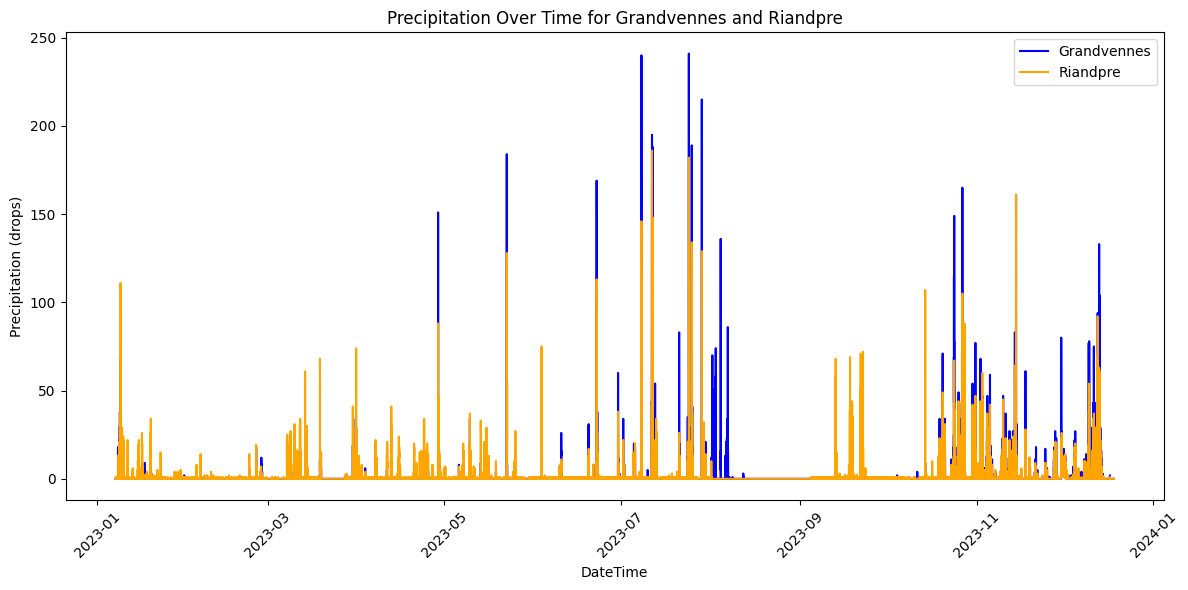

In [6]:
# Plotting the data for both stations
plt.figure(figsize=(12, 6))

# Plot Grand-Vennes data
plt.plot(grandvennes_aligned.index, grandvennes_aligned['Precipitation'], label='Grandvennes', color='blue')

# Plot Riand-Pré data
plt.plot(riandpre_aligned.index, riandpre_aligned['Precipitation'], label='Riandpre', color='orange')

# Add labels and title
plt.xlabel('DateTime')
plt.ylabel('Precipitation (drops)')
plt.title('Precipitation Over Time for Grandvennes and Riandpre')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Final step to merge the datasets

In [7]:
# Merge the datasets on the 'DateTime' index
combined_data = pd.merge(grandvennes_aligned[['Precipitation']],
                         riandpre_aligned[['Precipitation']],
                         left_index=True, right_index=True,
                         suffixes=('_Grandvennes', '_Riandpre'))

# Display the first few rows of the combined data
print("Combined Precipitation Data:")
print(combined_data.head())
print(combined_data.shape)

Combined Precipitation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0
2023-01-07 08:42:00                        0.0                     0.0
(132229, 2)


**1.1 Splitting dataset**

Split the dataset following this repartition
- First 70% = Training set
- Next 15% = Validation set  
- Last 15% = Testing set

In [8]:
# Calculate the index for the splits
train_size = int(0.7 * len(combined_data))  # 70% for training
val_size = int(0.15 * len(combined_data))  # 15% for validation
test_size = len(combined_data) - train_size - val_size  # 15% for testing

# Split the data sequentially
train_data = combined_data[:train_size]
val_data = combined_data[train_size:train_size + val_size]
test_data = combined_data[train_size + val_size:]

# Display the sizes of each dataset
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(train_data.head())

print("\nValidation Data:")
print(val_data.head())

print("\nTest Data:")
print(test_data.head())


Training set size: 92560
Validation set size: 19834
Test set size: 19835

Training Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0
2023-01-07 08:42:00                        0.0                     0.0

Validation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-09-26 19:18:00                        0.0                     0.0
2023-09-26 19:21:00                        0.0                     0.0
2023-09-26 19:24:00                        0.0                     0.0
2023-09-26 19:27:00                      

In [9]:
# Extract X for each dataset
# For training data
X_train = train_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# For validation data
X_valid = val_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# For test data
X_test = test_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# Display the first few rows of the extracted data
print("X_train:")
print(X_train.head())

print("\nX_valid:")
print(X_valid.head())

print("\nX_test:")
print(X_test.head())

X_train:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0
2023-01-07 08:42:00                        0.0                     0.0

X_valid:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-09-26 19:18:00                        0.0                     0.0
2023-09-26 19:21:00                        0.0                     0.0
2023-09-26 19:24:00                        0.0                     0.0
2023-09-26 19:27:00                        0.0                     0.0
2023-09-26 19:30:00                        0.0            

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

X_valid_scaled = scaler.transform(X_valid)
X_valid = pd.DataFrame(X_valid_scaled, columns=X_valid.columns, index=X_valid.index)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Display the first few rows of the scaled data to verify
print("Scaled X_train:")
print(X_train.head())

print("\nScaled X_valid:")
print(X_valid.head())

print("\nScaled X_test:")
print(X_test.head())

Scaled X_train:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:30:00                  -0.051617               -0.118285
2023-01-07 08:33:00                  -0.051617               -0.118285
2023-01-07 08:36:00                  -0.051617               -0.118285
2023-01-07 08:39:00                  -0.051617               -0.118285
2023-01-07 08:42:00                  -0.051617               -0.118285

Scaled X_valid:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-09-26 19:18:00                  -0.051617               -0.118285
2023-09-26 19:21:00                  -0.051617               -0.118285
2023-09-26 19:24:00                  -0.051617               -0.118285
2023-09-26 19:27:00                  -0.051617               -0.118285
2023-09-26 19:30:00                  -0.0516

**1.2 Hyperparameter test**

**1..2 Evaluation of components range**

Using Bayesian Information Criterion. It is optimal for selecting the optimal model when the number of data points is large

The following number of components are tested:
10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200

In [11]:
# Range of components to evaluate
component_range = [10,20,30,40,50,60,70,80,90,100]

# Store results
models = {}
bic_scores = []
silhouette_scores = []

# Loop through the range of components
for n_components in component_range:
    # Create and fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)  # Assuming X_train is your data

    # Store the model and metrics
    models[n_components] = gmm
    bic_scores.append(gmm.bic(X_train))

    # Predict cluster labels
    labels = gmm.predict(X_train)

    # Calculate silhouette score
    silhouette = silhouette_score(X_train, labels)
    silhouette_scores.append(silhouette)



Vizualisation of BIC and Silhouette score for each n_component tested

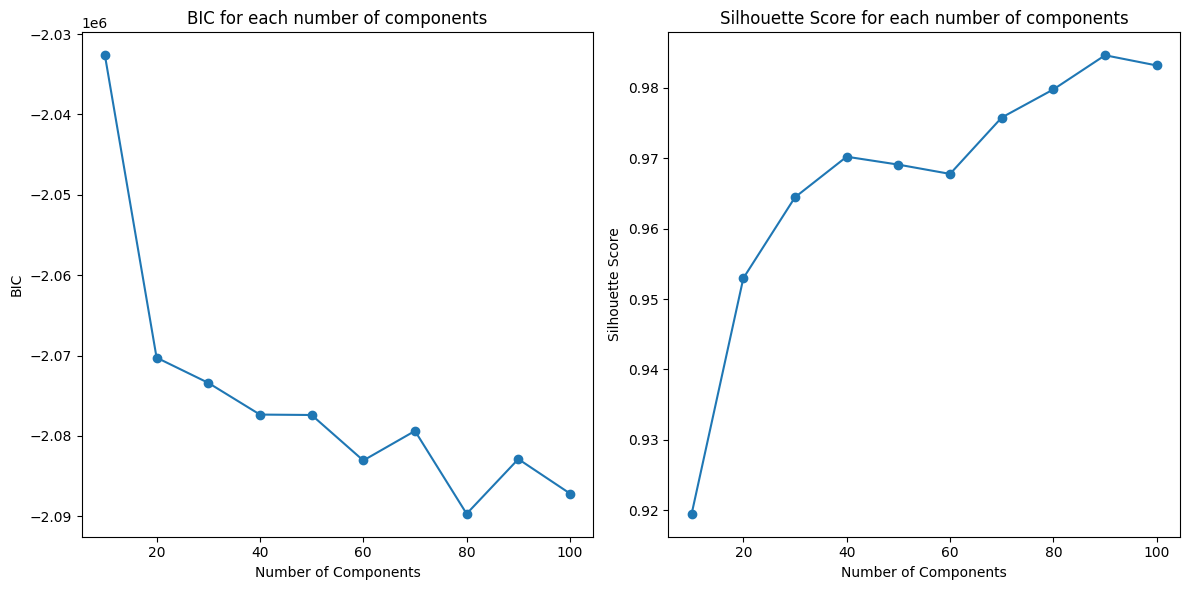

Best number of components: 80 based on BIC


In [12]:
# Plot BIC, and Silhouette Score for each number of components
plt.figure(figsize=(12, 6))


# Plot BIC
plt.subplot(1, 2, 1)
plt.plot(component_range, bic_scores, marker='o')
plt.title('BIC for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('BIC')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(component_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')

plt.tight_layout()

# Save the figure as a PDF
output_path = "plot_bic_silhouette_2_StationCorr.pdf"
plt.savefig(output_path, format='pdf')


plt.show()

# Select the best model based on the criteria you prefer (AIC, BIC, or silhouette score)
best_n_components = component_range[np.argmin(bic_scores)]
best_gmm_model = models[best_n_components]
print(f"Best number of components: {best_n_components} based on BIC")


**1.2.3 Combinatiton of hyperparameters**

Trying 4 co-variance option: full, tied, diagonal, spherical with the number of cluster range from 75 - 85. It is a range based on the 80 component detected with BIC.

In [13]:
#search for best combination of values for both the number of clusters
#and the covariance_type hyperparameter:

min_bic = np.infty

for k in range(75, 85):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X_train).bic(X_train)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

print('best_k')
print(best_k)
print('best_covariance_type')
print(best_covariance_type)



best_k
84
best_covariance_type
diag


**1.3 Initialization of Gaussian Mixture Model**

Initialization the model with the hyperparameter define in the previous section.

In [14]:
# Initialize the Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=84, covariance_type='diag', random_state=42)


In [15]:
# Fit the GMM model to the training data (X_train)
gmm.fit(X_train)

GaussianMixture(covariance_type='diag', n_components=84, random_state=42)

In [16]:
# Print the GMM parameters
print("Means of the components:\n", gmm.means_)
print("\nCovariances of the components:\n", gmm.covariances_)
print("\nWeights of the components:\n", gmm.weights_)

# Predict the component labels for each data point
component = gmm.predict(X_train)
proba = gmm.predict_proba(X_train)

# Display the predicted labels
print("Predicted component labels for the data points:\n", labels)
print("Predicted probabilities for each component:\n", proba)

Means of the components:
 [[-5.16173266e-02 -1.18284749e-01]
 [ 3.87689262e+01  4.17949299e+01]
 [ 4.40970661e+00  5.24855521e+00]
 [-5.16173266e-02  3.22029640e+00]
 [ 1.23353706e+01  1.26424252e+01]
 [ 8.31352616e+01  5.40350722e+01]
 [ 5.51881520e-01  1.16553295e+01]
 [-1.61558666e-02  9.94455463e-01]
 [ 5.85258099e+01  2.95547876e+01]
 [ 2.38646104e+01  2.02819525e+01]
 [ 1.75520641e+00  1.38021464e+00]
 [-5.16173266e-02  5.67491740e+00]
 [ 6.51114378e+01  5.47768990e+01]
 [ 1.12559133e+01  5.91386406e+00]
 [-5.16173266e-02  2.39910778e+01]
 [-5.16173266e-02  2.52628655e-01]
 [ 3.90106787e+00  2.53151875e+00]
 [ 3.42629702e+01  2.25074329e+01]
 [-5.16173266e-02  2.51551051e+00]
 [ 2.35179984e+01  4.10531031e+01]
 [ 2.05725207e+01  1.24989715e+01]
 [ 2.02824541e+00  2.00965468e+01]
 [ 5.81791979e+01  4.17949299e+01]
 [-5.16173266e-02  7.79750949e+00]
 [ 1.49686376e+01  2.30029650e+01]
 [ 7.09772998e+00  4.22740642e+00]
 [ 5.12469580e+01  2.91838742e+01]
 [-5.16173266e-02  4.24026179

**1.4 Evaluation of the model**

1.4.1 Train set

In [38]:
# Evaluate the log-likelihood of the trained GMM
log_likelihood = gmm.score(X_train)
print(f'Log-Likelihood: {log_likelihood}')


# Get the labels predicted by the GMM
labels = gmm.predict(X_train)

# Compute silhouette score
silhouette = silhouette_score(X_train, labels)
print(f'Silhouette Score: {silhouette}')


Log-Likelihood: 11.260896555808463
Silhouette Score: 0.9801683301659164


In [36]:
score = gmm.score_samples(X_train)

1.4.2. Validation set

In [18]:
Valid_score = gmm.score(X_valid)  # Log-likelihood score on test data
Valid_labels = gmm.predict(X_valid)  # Cluster labels for test data
silhouette = silhouette_score(X_valid, Valid_labels)  # Silhouette score

print(f"Log-likelihood on test set: {Valid_score}")
print(f"Silhouette score on test set: {silhouette}")

Log-likelihood on test set: 9.446482391413271
Silhouette score on test set: 0.9129380290891344


1.4.3. Test set

In [19]:
test_score = gmm.score(X_test)  # Log-likelihood score on test data
test_labels = gmm.predict(X_test)  # Cluster labels for test data
silhouette = silhouette_score(X_test, test_labels)  # Silhouette score

print(f"Log-likelihood on test set: {test_score}")
print(f"Silhouette score on test set: {silhouette}")


Log-likelihood on test set: 7.959973556760026
Silhouette score on test set: 0.8540421161835302


In [20]:
# Calculate BIC for training data
train_bic = gmm.bic(train_data)
print(f"BIC (Train): {train_bic}")

# Similarly, calculate BIC for validation and test data
val_bic = gmm.bic(val_data)
print(f"BIC (Validation): {val_bic}")

test_bic = gmm.bic(test_data)
print(f"BIC (Test): {test_bic}")


BIC (Train): 3505119.217448047
BIC (Validation): 786294.5938412747
BIC (Test): 742234.8565427297


**1.5 Anomalies identification**

1.5.1 Train set

In [28]:
# Compute log-probabilities for data
log_probs = gmm.score_samples(X_train)

threshold = np.percentile(gmm.score_samples(X_train), 5)  # 5th percentile
anomalies = X_train[log_probs < threshold]
print(anomalies.shape)

(4068, 2)


1.5.2 Test set

In [29]:
# Compute log-probabilities for data
log_probs = gmm.score_samples(X_test)

threshold = np.percentile(gmm.score_samples(X_test), 5)  # 5th percentile
anomalies_test = X_test[log_probs < threshold]
print(anomalies_test.shape)

(990, 2)


**1.6 Visualization**

<ipython-input-30-467ece2afe67>:25: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(xx, yy, Z, levels=np.logspace(-11, -2, 20), cmap='Blues', norm=LogNorm(), alpha=0.7)


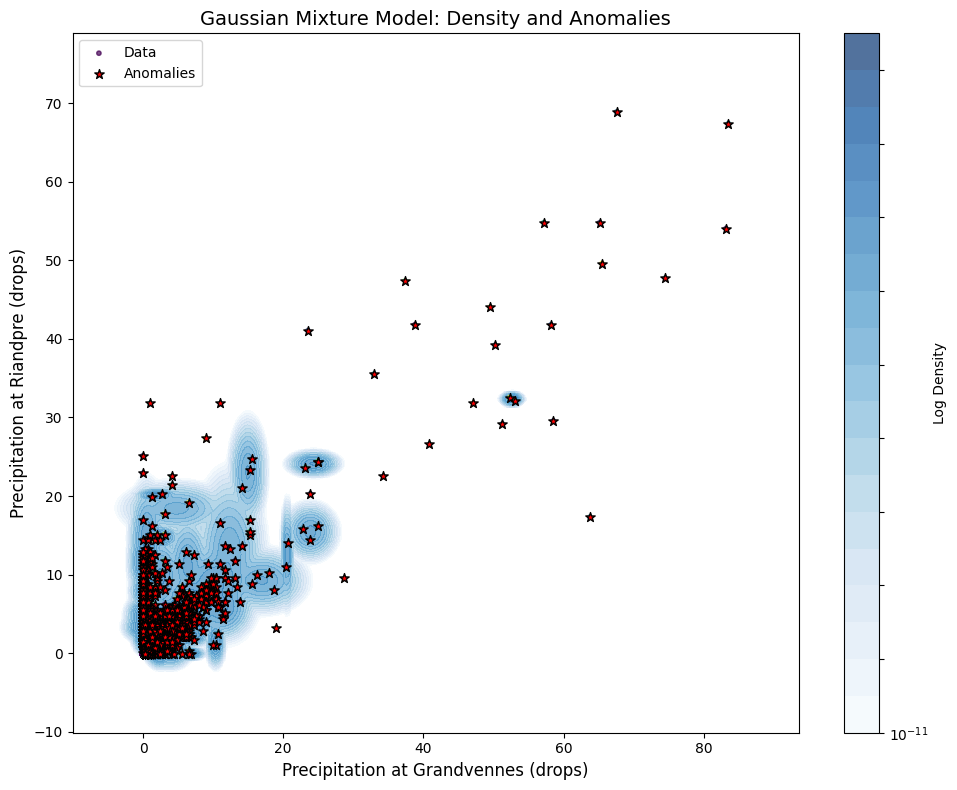

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# Ensure grid_points has the correct feature names, if necessary.

# Determine the full range of data
x_min = min(X_train['Precipitation_Grandvennes'].min(), anomalies['Precipitation_Grandvennes'].min()) - 10
x_max = max(X_train['Precipitation_Grandvennes'].max(), anomalies['Precipitation_Grandvennes'].max()) + 10
y_min = min(X_train['Precipitation_Riandpre'].min(), anomalies['Precipitation_Riandpre'].min()) - 10
y_max = max(X_train['Precipitation_Riandpre'].max(), anomalies['Precipitation_Riandpre'].max()) + 10

# Create grid points for contours within the new limits
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
grid_points_named = pd.DataFrame(grid_points, columns=['Precipitation_Grandvennes', 'Precipitation_Riandpre'])

# Compute density and reshape
Z = gmm.score_samples(grid_points_named)
Z = np.exp(Z)
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 8))
contour = plt.contourf(xx, yy, Z, levels=np.logspace(-11, -2, 20), cmap='Blues', norm=LogNorm(), alpha=0.7)
plt.colorbar(contour, label="Log Density")

plt.scatter(X_train['Precipitation_Grandvennes'], X_train['Precipitation_Riandpre'],
            c=labels, cmap='viridis', s=10, alpha=0.7, label="Data")
plt.scatter(anomalies['Precipitation_Grandvennes'], anomalies['Precipitation_Riandpre'],
            c="red", s=50, marker='*', edgecolor='black', label="Anomalies")

# Set axis limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title("Gaussian Mixture Model: Density and Anomalies", fontsize=14)
plt.xlabel("Precipitation at Grandvennes (drops)", fontsize=12)
plt.ylabel("Precipitation at Riandpre (drops)", fontsize=12)
plt.legend(loc='upper left', fontsize=10, frameon=True)
plt.tight_layout()

# Save the figure as a PDF
output_path2 = "anomalies_improved_2Sta_Corr.pdf"
plt.savefig(output_path2, format='pdf')

plt.show()